In [108]:
from typing import Literal, Union

import matplotlib as mpl
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import lognorm, norm

In [21]:
mpl.style.use('seaborn')
sns.set_style('whitegrid')
rc_pars = {'legend.facecolor': 'white', 'legend.framealpha': 0.85, "lines.linewidth": 3,
           'legend.edgecolor':'Black', 'legend.frameon': True,
           'legend.fancybox': True, 'legend.shadow': False,
           'figure.figsize': [10, 7],'figure.dpi': 300}
# 'axes.labelsize': 28, 'xtick.labelsize': 24, 'font.size': 28,
# 'ytick.labelsize': 24, 'axes.titlesize': 28,
# 'legend.title_fontsize':22, 'legend.fontsize': 22})
sns.set_context('talk',  rc=rc_pars )

C:\Users\Ron Sender\AppData\Local\Temp\ipykernel_21544\2669613937.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


### Orentreich et al. 1984
Trying to fit a lognormal distributino to the logmean and range

#### Women

In [3]:
mu = 2277
sig = 0.409
dist_f_oren = lognorm(s=sig, scale=mu)
dist_f_oren.ppf([0.05, 0.95])

array([1161.96629694, 4462.030451  ])

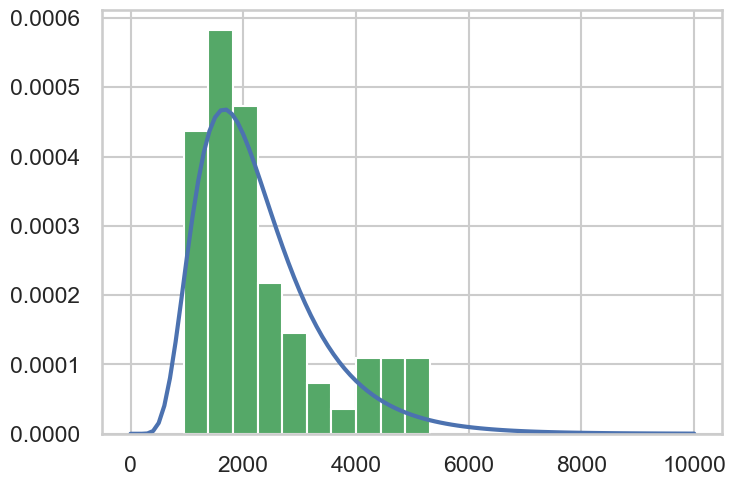

In [56]:
df_vals = pd.read_excel("DHEA-S & Adiponectin levels.xlsx", sheet_name="discrete data")
df_oren = df_vals[df_vals.source.eq("Orentreich et al. 1984")]
oren_log_vals = df_oren["value in log"].repeat(df_oren["n"]).values
10**oren_log_vals.mean().round(2), 10**oren_log_vals.std().round(2)
oren_vals = df_oren["value"].repeat(df_oren["n"]).values
oren_vals.std() * (1+np.log(2))
x= np.linspace(0,10**4,101)
fitted_params = lognorm.fit(oren_vals, floc=0)
fitted_dist = lognorm(s=fitted_params[0], scale=fitted_params[2])

ax = plt.figure().gca()
ax.plot(x, fitted_dist.pdf(x))

ax.hist(oren_vals, density=True);

#### Men

In [4]:
mu = 3120
sig = 0.353
dist_f_oren = lognorm(s=sig, scale=mu)
dist_f_oren.ppf([0.05, 0.95])

array([1745.77690006, 5575.97021686])

### Steffes et al. 2004

#### Men
We data regarding some of the quantiles and the geomean (which is similar to the median)

- for white men
- geomean 8.3 mg/L
- n=750
- (5th, 25th, 50th, 75th, 95th) 3.6, 6.0, 8.4, 12.0, 18.0 mg/L 

#### Women
- for white women
- geomean 13.6 mg/L 
- n=865
- (5th, 25th, 50th, 75th, 95th) 6.0, 10.0, 14.0, 19.0, 27.6 mg/L



Optimized Parameters for men distribution
Shape Parameter (s): 0.47
Scale Parameter (scale): 8.4

Optimized Parameters for women distribution
Shape Parameter (s): 0.44
Scale Parameter (scale): 13.7



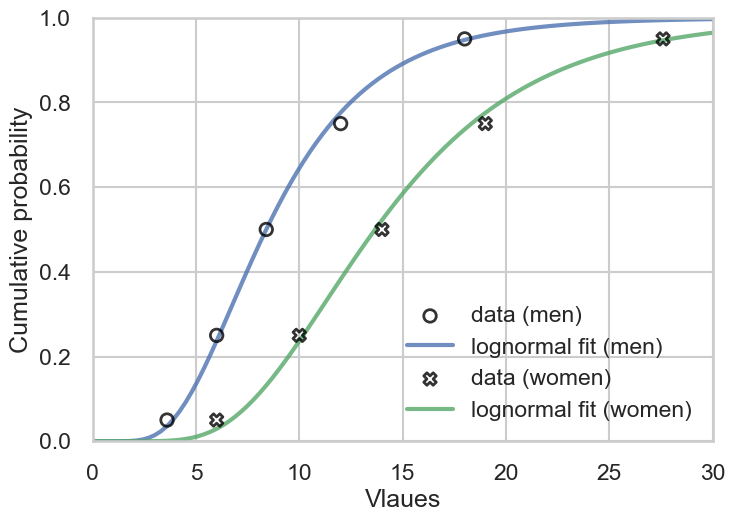

In [53]:
# Your data - percentiles and corresponding values
percentiles = np.array([0.05, 0.25, 0.5, 0.75, 0.95])
perc_values = {
    "men": np.array([3.6, 6.0, 8.4, 12.0, 18.0]),
    "women": np.array([6.0, 10.0, 14.0, 19.0, 27.6]),
}


# Define the objective function for least squares
def objective_function(
    params,
    percentiles,
    values,
):
    # Params: [s, loc, scale] where s is the shape parameter, loc is the location parameter, and scale is the scale parameter
    s, scale = params
    # Calculate the differences between the actual percentiles and the percentiles of the fitted lognormal distribution
    fitted_percentiles = stats.lognorm.ppf(percentiles, s=s, loc=0, scale=scale)
    differences = fitted_percentiles - values
    # Return the sum of squared differences
    return np.sum(differences**2)


# Initial guess for parameters
initial_guess = [0.5, 8] 

def fit_lognormal(values):
    result = minimize(
        objective_function,
        initial_guess,
        args=(percentiles, values),
        method="Nelder-Mead",
    )
    s_opt, scale_opt = result.x
    return s_opt, scale_opt


# Fit lognormal distribution to each array
optimized_params = {d: fit_lognormal(val_data) for d, val_data in perc_values.items()}


fitted_distribution = {}
for d, params in optimized_params.items():
    print(f"Optimized Parameters for {d} distribution")
    print("Shape Parameter (s):", np.round(params[0], 2))
    print("Scale Parameter (scale):", np.round(params[1], 1))
    print()
    fitted_distribution[d] = stats.lognorm(s=params[0], loc=0, scale=params[1])


ax = plt.figure().add_subplot()
x = np.linspace(0, 30, 101)
markers = {"men": "o", "women": "X"}
for d, dist in fitted_distribution.items():
    ax.scatter(
        perc_values[d],
        percentiles,
        ls="None",
        label=f"data ({d})",
        edgecolor="k",
        facecolor="none",
        marker=markers[d],
        lw=2,
        alpha=0.8,
        zorder=3,
    )

    ax.plot(
        x,
        dist.cdf(x),
        label=f"lognormal fit ({d})",
        alpha=0.8,
    )
ax.set(
    xlim=(0, 30),
    ylim=(0, 1),
    xlabel="Vlaues",
    ylabel="Cumulative probability",
)
ax.legend()

## Bootstrapping

In [101]:
df_dd = pd.read_excel("DHEA-S & Adiponectin levels.xlsx", sheet_name="discrete data")
df_sources = pd.read_excel("DHEA-S & Adiponectin levels.xlsx", sheet_name="distributions")


In [269]:
df_dd.age = df_dd.age.replace("25-29", 27.5)
for sx in ["M", "F"]:
    g_size = df_dd[df_dd.source.eq("Adamczak et al. 2005") & df_dd.sex.eq(sx) & df_dd.age.between(20, 30)].shape[0]
    df_sources.loc[df_sources.Reference.eq("Adamczak et al. 2005") & df_sources.sex.eq(sx) , "Group size"] = g_size

In [105]:
def get_discrete_rv(
    source: str,
    sex: Literal["M", "F"] = "F",
    df_dd: pd.DataFrame = df_dd,
) -> stats.rv_discrete:
    inds = df_dd.source.eq(source) & df_dd.age.between(20, 30) & df_dd.sex.eq(sex)
    return stats.rv_discrete(
        values=(
            df_dd.loc[inds, "value_μg/ml"],
            df_dd.loc[inds, "n"] / df_dd.loc[inds, "n"].sum(),
        ),
    )


def get_representative_distribution(
    source_row: pd.Series,
    df_dd: pd.DataFrame = df_dd,
) -> Union[stats.rv_continuous, stats.rv_discrete]:
    if source_row.Distribution == "normal":
        return norm(loc=source_row["median_μg/ml"], scale=source_row["std"])
    elif source_row.Distribution == "lognormal":
        return lognorm(s=source_row["sigma"], scale=source_row["median_μg/ml"], loc=0)
    elif source_row.Distribution == "discrete":
        return get_discrete_rv(source=source_row["Reference"], sex=source_row["sex"], df_dd=df_dd)
    else:
        return np.nan

In [270]:
df_sources["dist"] = df_sources.apply(get_representative_distribution, axis=1)
df_sources

sex Population: \nSex, ages  Group size  \
0    M                M, 20-30          10   
1    M                M, 25-29         151   
2    M                M, 21-30           7   
3    F                F, 20-30          10   
4    F                F, 25-29          63   
5    F                F, 21-25           9   
6    M             M, 27.5±1.8           8   
7    M                 M, 35±8           8   
8    M            M, 40.3±12.2          76   
9    M                M, 18-30         750   
10   F             F, 27.8±2.5           8   
11   F                 F, 36±9           5   
12   F            F, 36.3±10.8          40   
13   F                F, 18-30         865   

                      Measure of central tendency  \
0                                   mean\n11.5 uM   
1                            log mean\n3320 ng/ml   
2                                    mean\n9.6 uM   
3                                    mean\n6.2 uM   
4                            log mean\n2040 ng/ml   
5                                    mean\n8.8 uM   
6                               mean\n16.4 ug/ml*   
7                                 mean\n9.6 ug/ml   
8                                mean\n14.5 ug/ml   
9     Geometric mean \n8.3 mg/L\nmedian\n8.4 mg/L   
10                              mean\n19.3 ug/ml*   
11                               mean\n11.7 ug/ml   
12                               mean\n17.2 ug/ml   
13  geometric mean \n13.6 mg/L\nmedian\n14.0 mg/L   

                             Measure of dispersion Mass\n mean ±SD [ug/ml]  \
0                SEM of duplicate sample\n± 1.0 uM              4.2±1.20.5   
1   90% CI (log space M, 15-39)\n1,500-5,500 ng/ml                   3.3±?   
2                                  95%CI\n± 1.3 uM                3.5±0.53   
3                SEM of duplicate sample\n± 0.5 uM                2.3±0.63   
4   90% CI (log space F, 15-29)\n1,000-5,000 ng/ml                   2.0±?   
5                                  95%CI\n± 0.9 uM                 3.2±0.5   
6                                  SEM\n1.6 ug/ml*                16.4±4.5   
7                                    SD\n5.7 ug/ml                 9.6±5.7   
8                                    SD\n4.7 ug/ml                14.5±4.7   
9                        25th-75th %ile IQR: 6mg/L                 8.3±5.2   
10                                 SEM\n2.4 ug/ml*                19.3±6.8   
11                                   SD\n4.9 ug/ml                11.7±4.9   
12                                   SD\n5.2 ug/ml                17.2±5.2   
13                    25th-75th %ile IQR: 9.0 mg/L                13.6±7.7   

   Molarity mean±SD\n[uM]                   Reference      Hormone  \
0   11.5±3.2\n1.4\nCV=28%          Labrie et al. 1997       DHEA-S   
1                    9.0±      Orentreich et al. 1984       DHEA-S   
2      9.6±1.40.8\nCV=15%         Sulcová et al. 1997       DHEA-S   
3      6.2±1.60.7\nCV=26%          Labrie et al. 1997       DHEA-S   
4                    5.5±      Orentreich et al. 1984       DHEA-S   
5                 8.8±1.4         Sulcová et al. 1997       DHEA-S   
6                 0.6±0.2        Ferguson et al. 2004  Adiponectin   
7                 0.3±0.2        Adamczak et al. 2005  Adiponectin   
8                 0.5±0.2  Fernández-Real et al. 2005  Adiponectin   
9                 0.3±0.2         Steffes et al. 2004  Adiponectin   
10                0.7±0.2        Ferguson et al. 2004  Adiponectin   
11                0.4±0.2        Adamczak et al. 2005  Adiponectin   
12                0.6±0.2  Fernández-Real et al. 2005  Adiponectin   
13                0.5±0.3         Steffes et al. 2004  Adiponectin   

   Distribution  median_μg/ml  sigma       sem       std  \
0        normal      4.237607    NaN  0.368488  1.105463   
1     lognormal      3.120000   0.40       NaN       NaN   
2      discrete      3.537481    NaN       NaN       NaN   
3        normal      2.284623    NaN  0.184244  0.5527

In [271]:
N = 1000
seed = 1354
df_samples = pd.DataFrame()
for ind, row in df_sources[df_sources.Reference.ne("Fernández-Real et al. 2005")].iterrows():
    df_samples = pd.concat(
        [
            df_samples,
            pd.DataFrame(
                row.dist.rvs(
                    size=(row["Group size"], N),
                    random_state=seed,
                ),
                index=pd.Index(
                    [
                        f"{row.Reference[:3]}_{row.sex}_{i}"
                        for i in range(row["Group size"])
                    ],
                    name="participent",
                ),
                columns=pd.Index(range(N), name="run"),
            ).assign(
                # source=row.Reference,
                sex=row.sex,
                hormone=row.Hormone
            ),
        ]
    )

c:\Users\Ron Sender\Dropbox (Weizmann Institute)\Human Cells\Hormones project\hormones_distribution\horm_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Ron Sender\Dropbox (Weizmann Institute)\Human Cells\Hormones project\hormones_distribution\horm_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Ron Sender\Dropbox (Weizmann Institute)\Human Cells\Hormones project\hormones_distribution\horm_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cate

0.025     0.050     0.100      0.250      0.500  \
hormone     sex                                                       
Adiponectin F    5.781443  6.639597  7.801406  10.224675  13.724940   
            M    3.348376  3.881636  4.599946   6.144809   8.465965   
DHEA-S      F    1.059254  1.059254  1.203004   1.496236   1.883649   
            M    1.409525  1.614611  1.896492   2.442634   3.217701   

                     0.750      0.900      0.950      0.975  
hormone     sex                                              
Adiponectin F    18.471185  24.089580  28.171949  32.207352  
            M    11.642517  15.563954  18.338680  21.074409  
DHEA-S      F     2.914183   4.216965   4.731513   5.300960  
            M     4.234280   5.346736   5.940230   6.603616

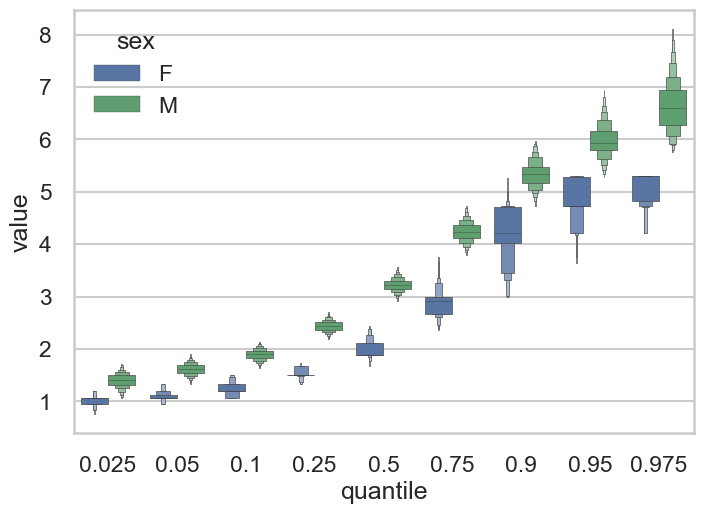

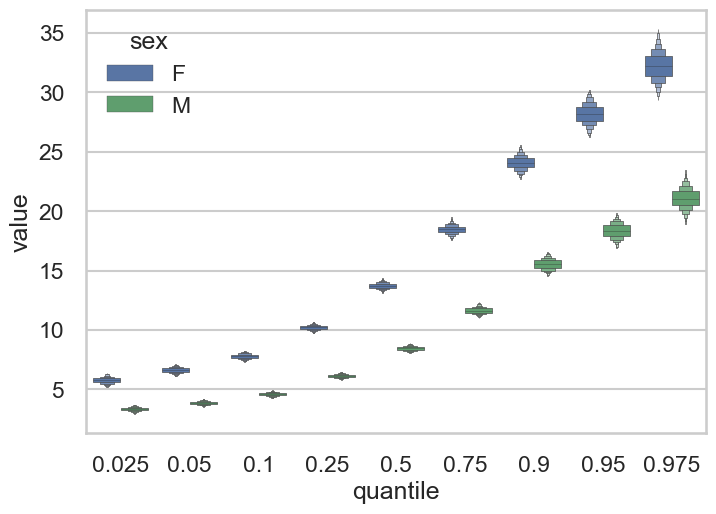

In [272]:
df_melt = df_samples.reset_index().melt(id_vars=["participent", "sex", "hormone"])
percentiles = [0.025, 0.05, 0.1 , 0.25, 0.50, 0.75, 0.9, 0.95, 0.975]
quants = df_melt.groupby(["hormone", "sex", "run"])["value"].quantile(percentiles).unstack("run")

quants_reshaped = quants.stack("run").reset_index(level=[1, 2]).rename(columns={"level_2": "quantile", 0:"value"})
sns.boxenplot(
    data=quants_reshaped.loc["DHEA-S"],
    x="quantile",
    hue="sex",
    y="value",
    linewidth=0.5,
    showfliers=False,
)
plt.figure()
sns.boxenplot(
    data=quants_reshaped.loc["Adiponectin"],
    x="quantile",
    hue="sex",
    y="value",
    linewidth=0.5,
    showfliers=False
)

quants.median(axis=1).unstack(2)

c:\Users\Ron Sender\Dropbox (Weizmann Institute)\Human Cells\Hormones project\hormones_distribution\horm_venv\lib\site-packages\scipy\stats\_stats_py.py:197: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
c:\Users\Ron Sender\Dropbox (Weizmann Institute)\Human Cells\Hormones project\hormones_distribution\horm_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Ron Sender\Dropbox (Weizmann Institute)\Human Cells\Hormones project\hormones_distribution\horm_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Ron Sender\Dropbox (Weizmann Institute)\Human Cells\Hormones project\hormones_dist

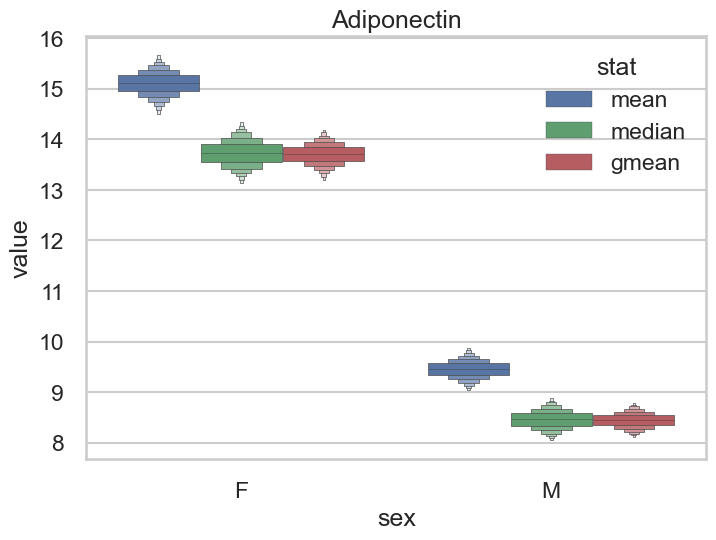

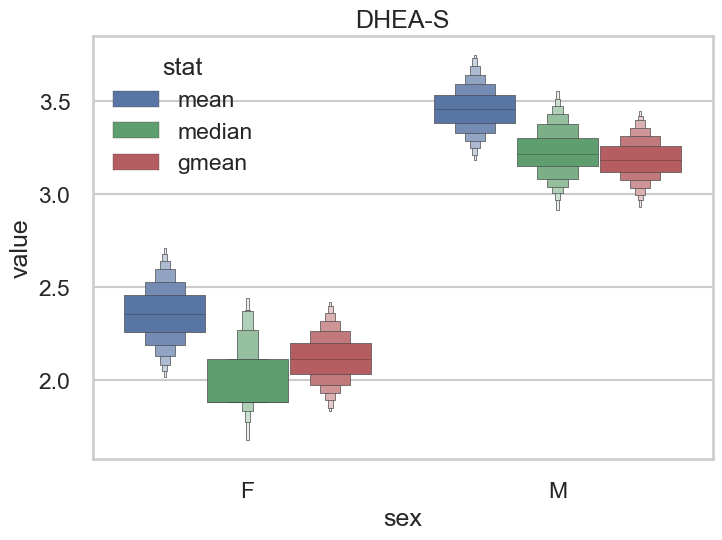

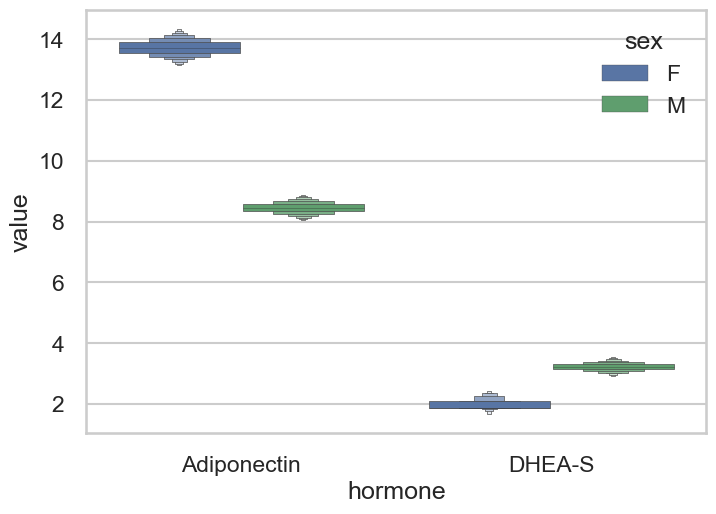

In [273]:
from scipy.stats import gmean
aggs = df_melt.groupby(["hormone", "sex", "run"])["value"].agg(["mean", "median", gmean]).reset_index()
aggs = aggs.melt(
    id_vars=["hormone", "sex", "run"],
    var_name="stat",
)
aggs=aggs.assign(hormon_stat=aggs.apply(lambda row: f"{row.hormone}-{row.stat}", axis=1))
for h in aggs.hormone.unique():
    plt.figure()
    ax = sns.boxenplot(
        data=aggs[aggs.hormone.eq(h)],
        x ="sex",
        y="value",
        hue="stat",
        linewidth=0.5,
        showfliers=False,
    )
    ax.set(
        title=h,
    )

plt.figure()
ax = sns.boxenplot(
    data=aggs[aggs.stat.eq("median")],
    x="hormone",
    y="value",
    hue="sex",
    linewidth=0.5,
    showfliers=False,
)



In [274]:
median_estimates = aggs[aggs.stat.eq("median")].groupby(["hormone","sex"])["value"].quantile([0.025, 0.5, 0.975]).unstack(level=2).round(2)
median_estimates["estimate"] = median_estimates[0.5].round(1)
median_estimates["CI95%"] = median_estimates.apply(lambda row: f"{row[0.025]:0.1f}-{row[0.975]:0.1f}", axis=1)
median_estimates

0.025    0.5  0.975  estimate      CI95%
hormone     sex                                          
Adiponectin F    13.22  13.72  14.23      13.7  13.2-14.2
            M     8.11   8.47   8.81       8.5    8.1-8.8
DHEA-S      F     1.81   1.88   2.37       1.9    1.8-2.4
            M     3.00   3.22   3.49       3.2    3.0-3.5

In [275]:
quants.median(axis=1).unstack(2).apply(
    lambda row: pd.Series(
        {
            "95%": f"{row[0.025]:0.1f}-{row[0.975]:0.1f}",
            "90%": f"{row[0.05]:0.1f}-{row[0.95]:0.1f}",
            "50%": f"{row[0.25]:0.1f}-{row[0.75]:0.1f}",
        }
    ),
    axis=1,
)

95%       90%        50%
hormone     sex                               
Adiponectin F    5.8-32.2  6.6-28.2  10.2-18.5
            M    3.3-21.1  3.9-18.3   6.1-11.6
DHEA-S      F     1.1-5.3   1.1-4.7    1.5-2.9
            M     1.4-6.6   1.6-5.9    2.4-4.2

In [276]:
df_melt.loc[df_melt["value"].le(0), "value"] = 0.001

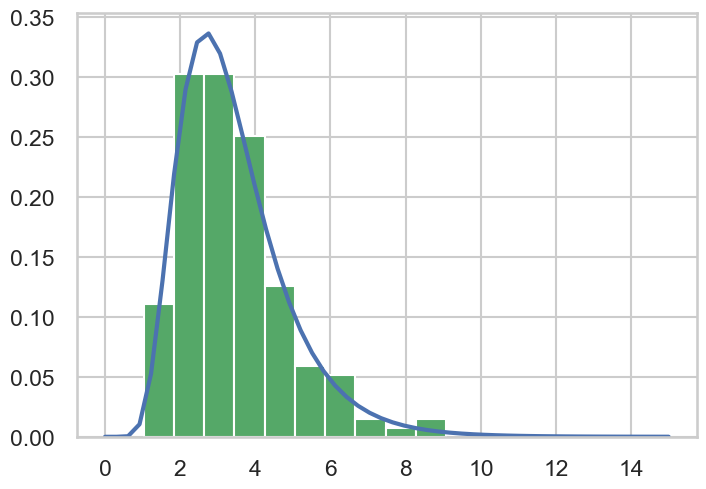

In [277]:
values = df_melt.loc[df_melt.hormone.eq("DHEA-S") & df_melt.sex.eq("M") & df_melt.run.eq(1), "value"]


x= np.linspace(0,15)

fitted_dist = lognorm(s=fitted_params[0], scale=fitted_params[2])

ax = plt.figure().gca()
ax.plot(x, fitted_dist.pdf(x))

ax.hist(values, density=True);

In [249]:
median_estimates

0.025    0.5  0.975  estimate      CI95%
hormone     sex                                          
Adiponectin F    13.22  13.65  14.17      13.6  13.2-14.2
            M     8.13   8.48   8.84       8.5    8.1-8.8
DHEA-S      F     1.81   1.88   2.37       1.9    1.8-2.4
            M     3.00   3.22   3.49       3.2    3.0-3.5